# Projeto: Análise e Predição de Churn de acordo com o perfil de clientes



<p align="center">
  <img src="telco.jpeg" >
</p>



**Churn é um grande problema para empresas de telecomunicação**. Com concorrência acirrada, adoção de novas (e custosas) tecnologias e altos custos de manutenção manter sua base de clientes é primordial para se manter relevante no mercado. Saber quais clientes podem deixar de assinar seus serviços pode evitar um churn em massa que pode desestabilizar suas operações.


Este projeto usa uma base de dados disponibilizada no [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn?select=WA_Fn-UseC_-Telco-Customer-Churn.csv) e visa analizar os clientes de uma empresa fictícia de telecom usando as várias técnicas aprendidas no curso de MBA de Data Science and Analytics do PECEGE - USP. 

As técnicas que pretendo usar aqui são:

- Análise Exploratória de Dados
- Arvore de Decisão
- Floresta de Decisão
- Logistica Binaria

Para começar, vamos estudar nossos dados vendo suas características.

Temos uma base de dados com 7043 linhas e 21 colunas distintas:
- Customer ID: Identificação de clientes, todas linhas únicas.
- Gender: Genero biológico da pessoa (Homem ou Mulher)
- SeniorCitizen: Se a pessoa é idosa (0 para não 1 para sim)
- Partner: Se a pessoa tem um parceiro/a (0 para não 1 para sim)
- Dependents: Se a pessoa tem dependentes (Yes or No)
- Tenure: A quantos meses o cliente é assinante
- PhoneService: Se a pessoa tem serviço de telefone ou não (Yes or No)
- Multiple Lines: Se a pessoa tem mais de uma linha (Yes, No or No Phone Service)
- Internet Service: Se a pessoa assina internet (DSL, Fiber Optic, No)
- OnlineSecurity: se ela assina o serviço de segurança online (Yes, No, No internet service)
- OnlineBackup: Se o cliente tem serviço de backup online (Yes, No, No internet service)
- DeviceProtection: Se o cliente tem proteção para seu dispositivo (Yes, No, No internet service)
- TechSupport: Se o cliente assina o suporte técnico (Yes, No, No internet service)
- StreamingTV: Se o cliente assina o serviço de streaming de TV (Yes, No, No internet service)
- StreamingMovies: Se o cliente assina o serviço de streaming de filmes (Yes, No, No internet service)
- Contract: Qual o tipo de contrato o cliente tem (mês a mês, um ano, dois anos)
- Paperless Billing: Se o cliente optou por faturas eletrônicas (Yes or No)
- PaymentMethod: Método de pagamento ('Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)')
- MonthCharges: Custos mensais do cliente
- TotalCharges: Custos totais do cliente
- Churn: Se o cliente saiu da empresa ou não, nossa variável alvo

Vamos dar uma olhada no resumo desses dados


In [ ]:
import pandas as pd
import csv
import collections, numpy

df = pd.read_csv('churn.csv')

print(df.head())
df.describe()
df['Contract'].unique()
#df['PaymentMethod'].unique()

# A coluna TotalCharges está como string, vou substituir valores nulos ou vazios por 0 e converter para float.
df['TotalCharges'].replace([' ','',' '],0,inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype({'TotalCharges': float})


#print('\nPorcentagem de Homens: %', (df['gender'].value_counts()[0]*100)/df['gender'].count())
#print('\nPorcentagem de Idosos: %', (df['SeniorCitizen'].value_counts()[1]*100)/df['SeniorCitizen'].count())
#print('\nPorcentagem de Pessoas com Parceiros: %', (df['Partner'].value_counts()[1]*100)/df['Partner'].count())
#print('\nPorcentagem de Pessoas com Dependentes: %', (df['Dependents'].value_counts()[1]*100)/df['Dependents'].count())
#print('\nPorcentagem de Churn: %', (df['Churn'].value_counts()[1]*100)/df['Churn'].count())


Não temos linhas sem valores, então não precisamos remediar isso na nossa base de dados.
Vamos ver a distribuição de valores de nossas variáveis por meio de histogramas.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig , ax = plt.subplots(nrows = 6, ncols = 3)
variaveis = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
'StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

i=0
j=0

for variavel in variaveis:
    sns.countplot(data = df, x = variavel, ax=ax[i][j])
    ax[i][j].set_title(variavel,fontdict= {'fontsize': 24})
    j = j + 1
    if j > 2:
        j = 0
        i = i + 1


sns.countplot(data = df, x = 'PaymentMethod', ax=ax[5][0])
labels = df['PaymentMethod'].unique()
ax[5][0].set_title('Método de Pagamento',fontdict= {'fontsize': 24})
ax[5][0].set_xticklabels(labels,rotation=30, ha= 'right')
sns.histplot(data = df, x = 'MonthlyCharges', ax=ax[5][1])
ax[5][1].set_title('Faturas Mensais',fontdict= {'fontsize': 24})
sns.countplot(data = df, x = 'Churn', ax=ax[5][2])
ax[5][2].set_title('Churn',fontdict= {'fontsize': 24})

sns.set(rc={'figure.figsize':(20,30)})

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df.sort_values(['tenure']).reset_index(drop=True)

fig , ax = plt.subplots(nrows = 2, ncols = 1)
sns.countplot(data = df, x = 'tenure', ax=ax[0])
ax[0].set_title('Meses Cliente',fontdict= {'fontsize': 28})
sns.histplot(data = df, x = 'TotalCharges', ax=ax[1], bins = 20)
ax[1].set_title('Faturamento Total',fontdict= {'fontsize': 28})

labels = df['tenure'].unique()
ax[0].set_xticklabels(labels,rotation = 90, ha= 'right')


sns.set(rc={'figure.figsize':(50,35)},font_scale=2)

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

produtos = df.copy(deep=True)
produtos = produtos.replace(['DSL','Fiber optic'],'Yes')

def internet_e_telefone(row):
    if row['InternetService'] == 'Yes' and row['PhoneService'] == 'Yes':
        val = 'Both'
    if row['InternetService'] == 'No' and row['PhoneService'] == 'Yes':
        val = 'Phone'
    if row['InternetService'] == 'Yes' and row['PhoneService'] == 'No':
        val = 'Internet'
    return val

def servico_extra(row):
    val = 'No'
    if row['OnlineSecurity'] == 'Yes' or row['OnlineBackup'] == 'Yes' or row['DeviceProtection'] == 'Yes' or row['TechSupport'] == 'Yes' or row['StreamingTV'] == 'Yes' or row['StreamingMovies'] == 'Yes':
        val = 'Yes'
    return val


produtos['TelefoneInternet'] = produtos.apply(internet_e_telefone,axis=1)
produtos['ContrataServiço'] = produtos.apply(servico_extra,axis=1)


fig , ax = plt.subplots(nrows = 4, ncols = 3)
font_size = 15

i=0
j=0

variaveis = ['PhoneService','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','TelefoneInternet','ContrataServiço']


for variavel in variaveis:
    sns.countplot(data = produtos, x = variavel, ax=ax[i][j])
    ax[i][j].set_title(variavel,fontdict= {'fontsize': font_size})
    j = j + 1
    if j > 2:
        j = 0
        i = i + 1



sns.set(rc={'figure.figsize':(20,15)})

Temos muitos dados interessantes em nossa base! É possível tirar vários insights!


Para melhor organizar as idéias, vamos usar bullet points:
- Os assinantes do serviço são homens, porém com uma pequena margem de vantagem (50,48% de homens);
- Uma pequena parcela dos assinantes são idosos (16%);
- Quase metade dos assinantes tem parceiros (48%);
- Os assinantes com dependentes fazem 30% da base de clientes.
- O serviço de telefonia é o produto mais popular;
- A maioria das pessoas assina a internet e o serviço de telefonia simultâneamente;
- Dos que contratam o serviço de Internet, a grande maioria contrata serviços adicionais como Streaming, Backup Online, etc...
- O serviço mais popular é o de Streaming de TV e Filmes e o menos popular é o de Segurança Online;
- Pelo gráfico de __tenure__ podemos ver que a maioria dos clientes da empresa são recém chegados ou já assinam seus produtos a mais de 71 meses;
- Tivemos um Churn de **26%** neste mês, ou seja, 1/4 de nossa base de clientes foi embora em um mês!!


Nessa próxima parte vamos analisar qual a porcentagem de churn para cada grupo de clientes.

In [ ]:
#Função para plotar gráficos Churn vs Coluna
def plot_churn(df,column):
    fig, ax = plt.subplots(1,2, figsize=(20,20))
    tmp1 = pd.crosstab(index = df[column], columns = df['Churn'], values = df['Churn'],
                               aggfunc = len,
                               normalize = 'index').mul(100)

    tmp2 = df[column].value_counts(normalize=True).mul(100)
    tmp1.plot.bar(stacked=True,figsize=(18,5),ax=ax[0], ylabel='%')
    tmp2.plot.bar(stacked=True,figsize=(18,5),ax=ax[1], ylabel='%')
    ax[1].set_title('{} Percentage'.format(column))
    ax[0].set_title('Churn Vs {}'.format(column))
    


#Churn por serviços
plot_churn(produtos,'PhoneService')
#Churn por Tipo de Serviço de Internet
plot_churn(df,'InternetService')
#Churn por serviço de internet
plot_churn(produtos,'InternetService')
#Churn por Tipo de Serviço de Internet
plot_churn(produtos,'TelefoneInternet')
#Churn por cliente que contrata servios de internet extras
plot_churn(produtos,'ContrataServiço')
#Churn por genêro
plot_churn(produtos,'gender')
#Churn por faixa de idade
plot_churn(produtos,'SeniorCitizen')
#Churn por situação marital
plot_churn(produtos,'Partner')
#Churn por dependentes
plot_churn(produtos,'Dependents')
#Churn por contratante de segurança online
plot_churn(produtos,'OnlineSecurity')
#Churn por contratante de backup online
plot_churn(produtos,'OnlineBackup')
#Churn por contratante de backup online
plot_churn(produtos,'StreamingTV')
#Churn por contratante de backup online
plot_churn(produtos,'StreamingMovies')
#Churn por contratante de backup online
plot_churn(produtos,'TechSupport')
#Churn por contratante de backup online
plot_churn(produtos,'DeviceProtection')


Novamente é possível de observar tendências bem interessantes no dados:

- Pessoas que contratam serviços de Internet extra tem uma taxa bem menor de Churn;
- Entre os assinantes de serviços de internet, os que mais deram churn foram os assinantes de Fibra Ótica;
- Clientes que só tem o serviço de telefone tem churn menor que clientes que tem ambos Telefone e Internet;
- O Churn é ligeiramente menor para assinantes de streamming TV e Filmes;
- O Churn é bem menor para clientes que assinam Suporte Tecnico e Segurança Online;
- Pessoas sem dependentes tem churn maior que as com dependentes.

Vamos agora começar a parte de implementação de modelos preditivos com uma arvore de decisão simples.

## Árvores de Decisão


O algoritmo de Árvore de decisão é um algortimo preditivo supervisionado, não parâmetrico, de Machine Learning, com estrutura hierarquica em forma de ávore com nó raiz, nós internos, galhos e folhas. O algoritmo visa criar uma sequência de segmentações binárias para alcançar a homogeniedade da variável resposta.

Para medir essa homogeniedade dentro das folhas é normalmente usado o indice Gini ou Entropia de Shannon, onde a impureza máxima é alcançada na distribuição uniforme e impureza mínima na concentração total.

O Algoritmo funciona deste modo:

1. Para cada variável, buscar a melhor regra binária
2. Escolher aplicar melhor segmentação dentre todas as variáveis
3. Recursivamente, para cada folha, repetir os passos 1 e 2 até que
uma regra de parada seja atingida

Após a criação de uma ávore podemos mudar os hiperparâmetros, que são parâmetros que controlam o algoritmo como:
1. Número mínimo de observações por folha
2. Profundidade máxima
3. CP – Custo de complexidade

E temos o nível de complexidade da árvore, que pode ser baixo, médio e alto.

Para cada variável vai ser criado um nó na árvore, com uma decisão binária, sendo que os primeiros nós são escolhidos de acordo com a variável que melhor consegue uma resposta homogenea daquele ponto.

As variáveis que vamos usar aqui para descobrir quem vai desistir dos serviços da empresa são:

- Gender: Genero biológico da pessoa (Homem ou Mulher)
- SeniorCitizen: Se a pessoa é idosa (0 para não 1 para sim)
- Partner: Se a pessoa tem um parceiro/a (0 para não 1 para sim)
- Dependents: Se a pessoa tem dependentes (Yes or No)
- PhoneService: Se a pessoa tem serviço de telefone ou não (Yes or No)
- Multiple Lines: Se a pessoa tem mais de uma linha (Yes, No or No Phone Service)
- Internet Service: Se a pessoa assina internet (DSL, Fiber Optic, No)
- OnlineSecurity: se ela assina o serviço de segurança online (Yes, No, No internet service)
- OnlineBackup: Se o cliente tem serviço de backup online (Yes, No, No internet service)
- DeviceProtection: Se o cliente tem proteção para seu dispositivo (Yes, No, No internet service)
- TechSupport: Se o cliente assina o suporte técnico (Yes, No, No internet service)
- StreamingTV: Se o cliente assina o serviço de streaming de TV (Yes, No, No internet service)
- StreamingMovies: Se o cliente assina o serviço de streaming de filmes (Yes, No, No internet service)
- Contract: Qual o tipo de contrato o cliente tem (mês a mês, um ano, dois anos)
- Paperless Billing: Se o cliente optou por faturas eletrônicas (Yes or No)
- PaymentMethod: Método de pagamento ('Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)')

E nossa variável alvo é:
- Churn: Se o cliente saiu da empresa ou não (Yes or No)

Primeiramente devemos separar nosso banco de dados entre treino e teste.
Esse passo é importante para sabermos se, de fato, nosso modelo vai funcionar em uma ocasião real, e nesse mesmo bloco vamos construir nossa arvore de decisão "padrão"

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import tree
import seaborn as sns
from sklearn.metrics import roc_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

#Como esse algoritmo só funciona com float, vamos ter que fazer labels numericas.


X = df.drop(['Churn','customerID'], axis=1)
y = df['Churn']
print(y)
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Vamos trocar labels em strings por labels numéricas no train seguindo:
#Passo 1 - Ident. colunas categoricas
#Passo 2- Aplicar o label encoder somente nas categoricas
#Guardar esse objeto para usar no teste

colunas_categoricas =[]

for column in X_train:
    try:
        X_train[column].iloc[0].isnumeric() == False

    except AttributeError:
        print (type(X_train[column][0]))

    else:
        colunas_categoricas.append(column)

le = preprocessing.LabelEncoder()

for coluna in colunas_categoricas:
    le.fit(X_train[coluna])
    X_train[coluna] = le.transform(X_train[coluna])
    X_test[coluna] = le.transform(X_test[coluna])

print(X_train)


#Vamos fazer nossa árvore de decisão setando todos os parâmetros como default


avore_de_decisao = DecisionTreeClassifier(random_state=0,
                                          criterion="gini",
                                          splitter="best",
                                          max_depth=None,
                                          min_samples_split=2,
                                          min_samples_leaf=1,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0,
                                          cpp_alpha=0)

avore_de_decisao.fit(X_train, y_train)

y_predicted = avore_de_decisao.predict(X_test)

training_score = cross_val_score(avore_de_decisao, X_train, y_train, cv=5)
print("O método de arvore de decisão teve um score de treino de: ", round(training_score.mean(), 2) * 100, "% de acurácia e um F1-Score de:", f1_score(y_test, y_predicted))


# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(arvore_de_decisao,   
#                   class_names='Churn',
#                    filled=True)

# fpr, tpr, _ = roc_curve(y_test, y_predicted)

# plt.clf()
# plt.plot(fpr, tpr)
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.title('ROC curve')
# plt.show()

# path = avore_de_decisao.cost_complexity_pruning_path(X_train,y_train)
# alphas=path['ccp_alphas']

# alphas

# confusion_matrix = pd.crosstab(y_test, y_predicted, rownames=['Actual'], colnames=['Predicted'])

# sns.heatmap(confusion_matrix, annot=True)
# plt.show()

#https://towardsdatascience.com/demystifying-roc-curves-df809474529a
 

## Checagem de resultados e métricas de performance

Para seguirmos com o ajuste de hiperparâmetros de nosso modelo, primeiro precisamos nos perguntar: Qual é a melhor métrica para nosso problema?
Precisamos saber se nosso modelo está bom ou ruim e levar em conta a estrutura dele e o problema que queremos resolver. Algumas métricas que podeusar usar são:

* Precisão:
    A precisão de um modelo é a proporção de quantas observações ele consegue "adivinhar" corretamente, normalmente medida em porcentagem. Se ele acertar 8 observações de 10, ele terá 80% de precisão. Porém aqui podemos ter um problema, suponhamos que em nossos dados tenhamos 90% de observações "1" e 10% de observações "2". Isso quer dizer que um modelo que somente retorne "1" tem 90% de precisão! Isso não diz nada sobre a qualidade do modelo e precisariamos de outra métrica para avaliar nosso modelo.

* F1-Score:
    F-1 Score é uma medida de precisão em um dataset, e é usado para avaliar sistemas de classificação binária, como é o caso de nossa árvore de decisão. Ele é composto pela média harmonica entre recall (ou sensibilidade) e precisão. A formula pode ser escrita como 2*((precisão*recall)/(precisão+recall)) ou tp/(tp+(fp+fn)/2), onde tp é "verdadeiro positivo", fp é "falso positivo" e fn é "falso negativo".

* Fbeta-Score:
    É uma adaptação do F1-Score onde colocamos mais importância para a precisão ou sensibilidade de um modelo. A formula é ( (1+b^2)*tp) / ((1+b^2)*tp + b^2*fn + fp) onde quanto maior o b maior importância vai ter o recall.

Agora, uma breve análise de nosso problema de negócios: Queremos evitar que clientes com o perfil de serem churn de fato virem churn, então se nosso modelo ser uma ótima precisão, mas uma sensibilidade baixa, não estamos resolvendo nosso problema pois estariamos classicando muitos clientes em risco de churn como falsos negativos e consequentemente não conseguiriamos direcionar nossos esforços de marketing para as pessoas corretas.

Vendo desta forma, julguei como a melhor métrica para nosso projetinho o Fbeta score, dando prioridade para uma maior sensibilidade de nosso modelo!

Agora podemos pensar em como ajustar os hiperparâmetros de nossa árvore para resolvermos nosso problema de negócio.



## Ajustando os Hiperparâmetros

Agoravamos ajustar os hiperparâmetros da árvore para conseguirmos generalizar nosso modelo, evitando overfit, e conseguir resolver nosso problema.

O primeiro hiperparâmetro que vamos estudar é o max_depth, que indica o quão "profunda" uma árvore de decisão pode ir. Quanto mais profunda mais informação dos dados ela irá capturar, mas daí corremos o risco de fazer um modelo que vai muito bem nos dados de treino, mas ruim nos dados de validação ou teste. Isso se chama overfitting.

O próximo é o hiperparâmetro min_samples_split, esse hiperparâmetro especifica o número minimo de amostras necessárias para dividir um nó interno. Se por exemplo, chegnado a um nó, só termos 500 observações e nosso parâmetro estiver setado em 700, o split não vai ocorrer.

Outro hiperparâmetro é o min_samples_leaf, um nó folha, ou só folha, é um nó tem filhos, ou a saída de nossa árvore. Esse parâmetro é o número mínimo de amostras necessárias para ser uma folha.

E o último é o max_features, que representa o número de features, ou variáveis, levadas em conta quando procuramos pelo melhor "split". ele leva como entrada um inteiro para denotar o numero máximo de variáveis para para "split" ou porcentagem de variáveis para considerar quando se faz um split.

O critério que vamos usar é o índice Gini para verificar a homogeniedade de nossos nós.

Vamos mudar cada um dos hiperparâmetros gradualmente, e colocar em um gráfico qual foi a mudança no nosso Fb-Score para cada um deles.


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


#Vamos variar max_depth de 3 até 50, para vermos como nosso overfitting e Kb-Score fica a cada nível que a arore cresce!    
#Aqui vamos adotar um b = 1.5.

accuracy_train,accuracy_test,f1_train,f1_test=[],[],[],[]

for i in range(3,31):
    arvore_de_decisao = DecisionTreeClassifier(random_state=0,
                                          criterion="gini",
                                          splitter="best",
                                          max_depth=i,
                                          min_samples_split=2,
                                          min_samples_leaf=1,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0
                                          )
    arvore_de_decisao.fit(X_train, y_train)

    
    if i < 6:
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(arvore_de_decisao,   
                        class_names='Churn',
                        filled=True)
        plt.show()

    y_train_pred=arvore_de_decisao.predict(X_train)
    y_test_pred=arvore_de_decisao.predict(X_test)
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

    f1_train.append(f1_score(y_train,y_train_pred))
    f1_test.append(f1_score(y_test,y_test_pred))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train,x=range(3,3+len(accuracy_train)), label="Precisão no Treino")
sns.lineplot(y=accuracy_test,x=range(3,3+len(accuracy_test)), label="Precisão no Teste")
plt.xticks(range(3,30,2))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=f1_train,x=range(3,3+len(f1_train)), label="F1 no Treino")
sns.lineplot(y=f1_test,x=range(3,3+len(f1_test)), label="F1 no Teste")
plt.xticks(range(3,30,2))
plt.show()

print(X_test.iloc[14])

Primeiramente quero comentar sobre o que achamos com as ávores plotadas aqui.

Podemos ver que o fator que melhor separa as pessoas que vão fazer churn das pessoas que não fazem é o X[14], que em nosso caso é Contrato, ou de quant oe mquanto tempo uma pessoa paga sua conta (mes a mes, ano a ano). Isso é um grande insight! Será que precisamos adaptar como fazemos nossos contratos?!

Agora voltando a nossa avaliação de precisão.
Ao ver o gráfico de profundade x precisão, vemos que nosso modelo consegue um pico no f1 score quando usamos uma árvore de profundidade 5!
Vamos agora fixar depth em 5 e variar min_samples_split entre 2 e 20 para observar o comportamento.

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import f1_score

#Vamos variar max_depth de 3 até 50, para vermos como nosso overfitting e Kb-Score fica a cada nível que a arore cresce!    
#Aqui vamos adotar um b = 1.5.

accuracy_train,accuracy_test,f1_train,f1_test=[],[],[],[]

for i in range(2,4001,200):
    arvore_de_decisao = DecisionTreeClassifier(random_state=0,
                                          criterion="gini",
                                          splitter="best",
                                          max_depth=5,
                                          min_samples_split=i,
                                          min_samples_leaf=1,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0
                                          )

    arvore_de_decisao.fit(X_train,y_train)

    if i == 2 or i == 202 or i==802 or i==2000 or i==4000:
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(arvore_de_decisao,   
                        class_names='Churn',
                        filled=True)
        plt.show()

    y_train_pred=arvore_de_decisao.predict(X_train)
    y_test_pred=arvore_de_decisao.predict(X_test)
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

    f1_train.append(f1_score(y_train,y_train_pred))
    f1_test.append(f1_score(y_test,y_test_pred))

    y_train_pred=arvore_de_decisao.predict(X_train)
    y_test_pred=arvore_de_decisao.predict(X_test)
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

    f1_train.append(f1_score(y_train,y_train_pred))
    f1_test.append(f1_score(y_test,y_test_pred))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train,x=range(2,2+(len(accuracy_train)*200),200), label="Precisão no Treino")
sns.lineplot(y=accuracy_test,x=range(2,2+(len(accuracy_test)*200),200), label="Precisão no Teste")
plt.xticks(range(2,len(accuracy_train)*200,200))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=f1_train,x=range(2,2+(len(f1_train)*200),200), label="F1 no Treino")
sns.lineplot(y=f1_test,x=range(2,2+(len(f1_test)*200),200), label="F1 no Teste")
plt.xticks(range(2,len(accuracy_train)*200,200))
plt.show()

Ao que podemos observar, maior o mínimo de observações para cada split, mais simples a árvore fica, tendendo a arvore de decisão termianr mais cedo dependendo da variável e nível na árvore.
Analisando os gráficos, podemos ver que o valor ideal para min_samples_split está entre 2 e 202. Será que usar 202 valeria a pena por diminuir a complexidade da árvore e obter os mesmos valores de precisão e f1 score?

Agora, vamos analizar o comportamento do hiperparâmetro min_samples_leaf=i.


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import f1_score

#Vamos variar max_depth de 3 até 50, para vermos como nosso overfitting e Kb-Score fica a cada nível que a arore cresce!    
#Aqui vamos adotar um b = 1.5.

accuracy_train,accuracy_test,f1_train,f1_test=[],[],[],[]

for i in range(2,2001,200):
    arvore_de_decisao = DecisionTreeClassifier(random_state=0,
                                          criterion="gini",
                                          splitter="best",
                                          max_depth=5,
                                          min_samples_split=200,
                                          min_samples_leaf=i,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0
                                          )

    arvore_de_decisao.fit(X_train,y_train)

    if i == 2 or i == 202 or i==802 or i==2000 or i==4000:
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(arvore_de_decisao,   
                        class_names='Churn',
                        filled=True)
        plt.show()

    y_train_pred=arvore_de_decisao.predict(X_train)
    y_test_pred=arvore_de_decisao.predict(X_test)
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

    f1_train.append(f1_score(y_train,y_train_pred))
    f1_test.append(f1_score(y_test,y_test_pred))

    y_train_pred=arvore_de_decisao.predict(X_train)
    y_test_pred=arvore_de_decisao.predict(X_test)
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

    f1_train.append(f1_score(y_train,y_train_pred))
    f1_test.append(f1_score(y_test,y_test_pred))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train,x=range(2,2+(len(accuracy_train)*200),200), label="Precisão no Treino")
sns.lineplot(y=accuracy_test,x=range(2,2+(len(accuracy_test)*200),200), label="Precisão no Teste")
plt.xticks(range(2,len(accuracy_train)*200,200))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=f1_train,x=range(2,2+(len(f1_train)*200),200), label="F1 no Treino")
sns.lineplot(y=f1_test,x=range(2,2+(len(f1_test)*200),200), label="F1 no Teste")
plt.xticks(range(2,len(accuracy_train)*200,200))
plt.show()

Podemos ver que o hiperparâmetro min_samples_leaf tem influência direta na profundidade máxima de uma árvore.
Isso é esperado, pois ela limita a criação de folhas que não cumpram com o número de observações minimo necessário para a criação de uma folha.

Ao que parece, em nosso caso, valores entre 2 e 200 neste problema parecem ser os ideais para alcançarmos uma boa assertividade do modelo.
Porém, quando o mesmo modelo é rodado com min_samples_node = 200 temos perda de f1 score e precisão! Isso porquê perdemos nós intermediáriso e temos perda de informação na árvore.

Será que precisamos analisar o comportamento destas duas variáveis ao mesmo tempo? Depois...

Agora vamos mexer no parâmetro max_leaf_nodes entre 2 e 50



In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import f1_score

#Vamos variar max_depth de 3 até 50, para vermos como nosso overfitting e Kb-Score fica a cada nível que a arore cresce!    
#Aqui vamos adotar um b = 1.5.

accuracy_train,accuracy_test,f1_train,f1_test=[],[],[],[]

for i in range(2,51):
    arvore_de_decisao = DecisionTreeClassifier(random_state=0,
                                          criterion="gini",
                                          splitter="best",
                                          max_depth=5,
                                          min_samples_split=2,
                                          min_samples_leaf=2,
                                          max_leaf_nodes=i,
                                          min_impurity_decrease=0
                                          )

    arvore_de_decisao.fit(X_train,y_train)

    if i == 2 or i == 10 or i==25 or i==40 or i==50:
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(arvore_de_decisao,   
                        class_names='Churn',
                        filled=True)
        plt.show()

    y_train_pred=arvore_de_decisao.predict(X_train)
    y_test_pred=arvore_de_decisao.predict(X_test)
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

    f1_train.append(f1_score(y_train,y_train_pred))
    f1_test.append(f1_score(y_test,y_test_pred))

    y_train_pred=arvore_de_decisao.predict(X_train)
    y_test_pred=arvore_de_decisao.predict(X_test)
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

    f1_train.append(f1_score(y_train,y_train_pred))
    f1_test.append(f1_score(y_test,y_test_pred))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train,x=range(2,2+(len(accuracy_train)),1), label="Precisão no Treino")
sns.lineplot(y=accuracy_test,x=range(2,2+(len(accuracy_test)),1), label="Precisão no Teste")
plt.xticks(range(2,len(accuracy_train),1))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=f1_train,x=range(2,2+(len(f1_train)),1), label="F1 no Treino")
sns.lineplot(y=f1_test,x=range(2,2+(len(f1_test)),1), label="F1 no Teste")
plt.xticks(range(2,len(accuracy_train),1))
plt.show()

Aqui nossos gráficos, tanto de precisão quanto de f1 score, tem comportamentos interessantes.

Há um pico de f1 score próximo de 0.6 quando adotamos o número máximo de folhas em 4 e 5. Após o ponto x=11 a precisão consegue superar o valor máximo anterior, mas o valor de F1 não!

O que será que isso significa?

O último parâmetro de estudo é min_impurity_decrease=0, que varia de 0 a 1, vamos dar uma olhada

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import f1_score


accuracy_train,accuracy_test,f1_train,f1_test=[],[],[],[]

for i in range(0,5):
    arvore_de_decisao = DecisionTreeClassifier(random_state=0,
                                          criterion="gini",
                                          splitter="best",
                                          max_depth=5,
                                          min_samples_split=2,
                                          min_samples_leaf=2,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=i/100
                                          )

    arvore_de_decisao.fit(X_train,y_train)

    if i == 0 or i == 1 or i==2 or i==3 or i==4:
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(arvore_de_decisao,   
                        class_names='Churn',
                        filled=True)
        plt.show()

    y_train_pred=arvore_de_decisao.predict(X_train)
    y_test_pred=arvore_de_decisao.predict(X_test)
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

    f1_train.append(f1_score(y_train,y_train_pred))
    f1_test.append(f1_score(y_test,y_test_pred))

    y_train_pred=arvore_de_decisao.predict(X_train)
    y_test_pred=arvore_de_decisao.predict(X_test)
    accuracy_train.append(accuracy_score(y_train,y_train_pred))
    accuracy_test.append(accuracy_score(y_test,y_test_pred))

    f1_train.append(f1_score(y_train,y_train_pred))
    f1_test.append(f1_score(y_test,y_test_pred))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train,x=range(2,2+(len(accuracy_train)),1), label="Precisão no Treino")
sns.lineplot(y=accuracy_test,x=range(2,2+(len(accuracy_test)),1), label="Precisão no Teste")
plt.xticks(range(2,len(accuracy_train),1))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=f1_train,x=range(0,(len(f1_train)),1), label="F1 no Treino")
sns.lineplot(y=f1_test,x=range(0,(len(f1_test)),1), label="F1 no Teste")
plt.xticks(range(2,len(accuracy_train),1))
plt.show()

Variando a min_impurity_decrease tivemos influência direta no número de nós e folhas criadas, assim como na profundidade da árvore, setando um minimo de mudança de impureza para a criação de um novo nó.

Esse parâmetro pode ser útil para evitarmos a criação de nós que não melhoram significativamente nossos resultados e adicionam complexidade a nossa árvore.

Esse parâmetro deve ser mexido com cuidado, pois usa valores decimais e é necessário atenção ao modelo criado.

## Comentários sobre o uso de Árvores de Decisão

A escrever

## Regressão Logística Binária


A regressão logística binária é um algoritmo supervisionado, tebdo fins preditivos, sendo um modelo de regressão linear generalizado, binário ou multinomial, que tem uma distribuição Bernoulli, tras um approach diferente a escolha de modelos preditivos categóricos binários. O modelo aceita features métricas e não métricas. É um método que calcula a probabilidade de uma observação ser classificada em uma categoria.


Antes de explicar melhor este método é importante estabelecer alguns conceitos base:

1. Probabilidade

Seja Y a resposta a um estimulo (sim ou não) - pode ser a preferência por algum produto, ou no nosso caso, churn ou não-churn.
p = probabilidade da resposta ser sim (ou churn)
1-p = probabilidade da resposta ser não (ou não-churn)

Para medir essa homogeniedade dentro das folhas é normalmente usado o indice Gini ou Entropia de Shannon, onde a impureza máxima é alcançada na distribuição uniforme e impureza mínima na concentração total.

2. Chance(odds)

A chance da ocorrência de um evento.

chance = p/1-p
se p = 0,50; chance = 1 (1 para 1)
se p = 0,75; chance = 3 (3 para 1)
se p = 0,25; chance = 1/3 (1 para 3)

3. Logito

É o logaritmo natural da chance de ocorrência de uma resposta do tipo “sim”.

E a partir dele que se define a expressão da probabilidade de ocorrência do evento em um estudo, em função das features.

A partir do logito é plottada a A curva logística, ou sigmóide, que descreve a relação entre a probabilidade associada à ocorrência de determinando
evento e um conjunto de features.

Como fazemos isso? E por que esse método é considerado um modelo linear gerenalizado?

Porque ela usa como base um vetor linear com as features, ou variáveis explicativas, na seguinte estrutura:


Z = a + b1*x1 + b2*x2 + b3*x3 .... by*xy


e a igualamos isso a


Z = ln(p/(1-p))


e dessa equação podemos isolar o p e assim termos:


p = 1/(1+e^(-Z))


Lembrando novamente que Z é onde nosso vetor com os termos da equação linear estão.

ou quer dizer, para estabelecermos os fatores de nossa regressão igualamos nosso vetor com o logaritmo natural das chances de um evento, isolamos p (probabilidade de evento) para
ficar em função de nosso vetor Z!!!

E para a estimação de parâmetros usamos um processo iterativo para maximizar o acerto da probabilidade de ocorrência de um evento a sua real ocorrência, pelo método da máxima verossimilhança. E lembrando que o resultado deste método é um número entre 0 e 1 para cada observação.

Com isso, vamos dar inicio a construção de nosso modelo base ou "standard".



<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
O método de arvore de decisão teve um score de treino de:  0.8062455642299503 % de acurácia e um F1-Score de: 0.588235294117647
[0.4557841449194362, 0.9743688097756015, 0.9709865239244292, 0.7980549311831453, 0.5812991243986203, 0.4572606968131091, 0.5538734922704565, 0.974651743259401, 0.5088261958089029, 0.21095629143593353, 0.982367240339991, 0.5234585053962744, 0.23132745492794593, 0.9962927472328321, 0.6160992110983279, 0.5473356270545048, 0.5402411516921939, 0.6491052561987699, 0.9698135386521041, 0.9825604992909004, 0.9318969626349906, 0.9897332483825192, 0.7226353236754458, 0.7954244280398834, 0.5930298166566017, 0.7028084778424262, 0.9842249249825705, 0.9544421865612199, 0.9950140006536592, 0.9888223576207998, 0.9637585598297064, 0.4549542718504276, 0.9849774201996186, 0.9988849222603933, 0.7492978224271363, 0.4116837648389926, 0.18673321798995657, 0.7372919535222202, 0.9880855324945231

C:\Users\eduar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Unable to coerce to Series, length must be 19: given 1

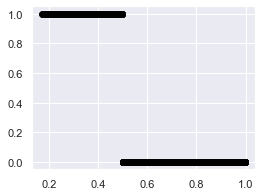

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from scipy.special import expit

#Como esse algoritmo só funciona com float, vamos ter que fazer labels numericas.


X = df.drop(['Churn','customerID'], axis=1)
y = df['Churn']
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Vamos trocar labels em strings por labels numéricas no train seguindo:
#Passo 1 - Ident. colunas categoricas
#Passo 2- Aplicar o label encoder somente nas categoricas
#Guardar esse objeto para usar no teste

colunas_categoricas =[]

for column in X_train:
    try:
        X_train[column].iloc[0].isnumeric() == False

    except AttributeError:
        print (type(X_train[column][0]))

    else:
        colunas_categoricas.append(column)

le = preprocessing.LabelEncoder()

for coluna in colunas_categoricas:
    le.fit(X_train[coluna])
    X_train[coluna] = le.transform(X_train[coluna])
    X_test[coluna] = le.transform(X_test[coluna])



#Vamos fazer nossa árvore de decisão setando todos os parâmetros como default


regressao_logistica = LogisticRegression(random_state=0,
                                      penalty="l2",
                                      dual=False,
                                      tol = 1e-4,
                                      fit_intercept = True,
                                      solver = 'lbfgs',
                                      max_iter=100)

regressao_logistica.fit(X_train, y_train)

y_predicted = regressao_logistica.predict(X_test)
y_probabilities_old = regressao_logistica.predict_proba(X_test)

y_probabilities = []

for i in range(0,len(y_probabilities_old)):
    y_probabilities.append(y_probabilities_old[i][0])

f1 = f1_score(y_test,y_predicted)
precisao = accuracy_score(y_test,y_predicted)
print("O método de arvore de decisão teve um score de treino de: ", precisao, "% de acurácia e um F1-Score de:", f1)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(y_probabilities, y_predicted, color="black", zorder=20)


loss = expit(X_test * regressao_logistica.coef_ + regressao_logistica.intercept_).ravel()
plt.plot(X_test, loss, color="red", linewidth=3)



plt.ylabel("y")
plt.xlabel("X")
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-0.25, 1.25)
plt.xlim(-4, 10)
plt.legend(
    ("Logistic Regression Model"),
    loc="lower right",
    fontsize="small",
)
plt.tight_layout()
plt.show()

# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(arvore_de_decisao,   
#                   class_names='Churn',
#                    filled=True)

# fpr, tpr, _ = roc_curve(y_test, y_predicted)

# plt.clf()
# plt.plot(fpr, tpr)
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.title('ROC curve')
# plt.show()

# path = avore_de_decisao.cost_complexity_pruning_path(X_train,y_train)
# alphas=path['ccp_alphas']

# alphas

# confusion_matrix = pd.crosstab(y_test, y_predicted, rownames=['Actual'], colnames=['Predicted'])

# sns.heatmap(confusion_matrix, annot=True)
# plt.show()


## Conclusões Da Análise


A maior lição que podemos tirar destes dados é que pessoas que contratam os serviços extra da empresa são menos propicias a sair do que pessoas que só contratam o serviço de internet.

também foi possível encontrar uma dispariedade de Churn entre pessoas que pagam com Electronic check e Mailed Check. Parece que pessoas que pagam com Electronic Check sairam mais dos serviços do que aqueles que pagam com Mailed Check.


Uma possível solução para mitigar o problema de churn da empresa é promover os serviços adicionais junto com o pacote de internet. Deste modo os clientes vão ter conhecimento destes serviços e podem contrata-los. A empresa também pode oferecer estes serviços de graça para pessoas que desejam cancelar a assinatura, garantindo-os como clientes.


Não podemos ignorar que a grande parte dos churn são de assinantes de fibra ótica. Será que temos algum problema com o serviço? Vale a pena investigar.